In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
from sklearn.feature_selection import mutual_info_regression
from typing import Any

df = pd.read_csv("Laptop_price.csv")
df.head()

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,Asus,3.830296,16,512,11.185147,2.641094,17395.093065
1,Acer,2.912833,4,1000,11.311372,3.260012,31607.605919
2,Lenovo,3.241627,4,256,11.853023,2.029061,9291.023542
3,Acer,3.806248,16,512,12.280360,4.573865,17436.728334
4,Acer,3.268097,32,1000,14.990877,4.193472,32917.990718


In [ ]:
df.isnull().sum()

Brand               0
Processor_Speed     0
RAM_Size            0
Storage_Capacity    0
Screen_Size         0
Weight              0
Price               0
dtype: int64

In [ ]:
from google.colab import drive

In [ ]:
encoded_data = pd.get_dummies(df, columns=['Brand'], prefix='Brand', drop_first=True)

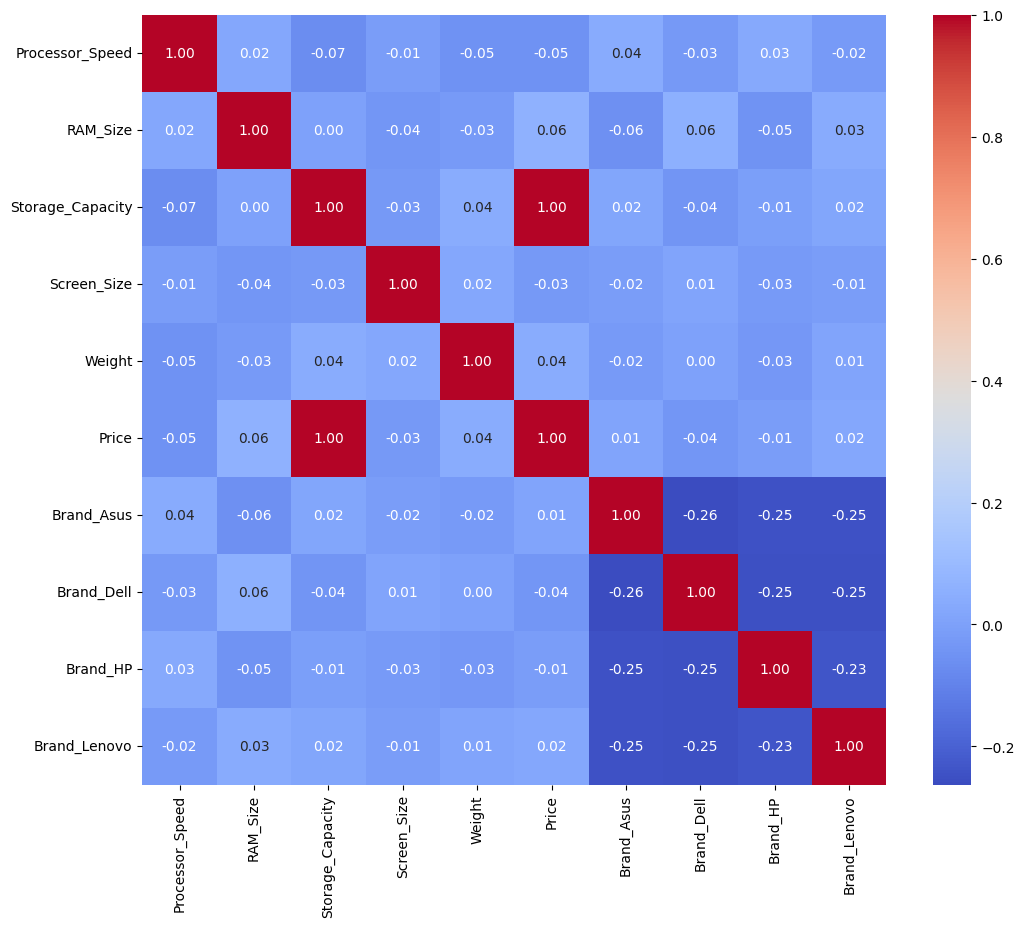

In [ ]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(encoded_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")

In [ ]:
target = "Price"

correlations = encoded_data.corr()[target].abs()
threshold = 0.3

selected_features = correlations[correlations > threshold].index.tolist()

selected_data = encoded_data[selected_features]
selected_data

,Storage_Capacity,Price
0,512,17395.093065
1,1000,31607.605919
2,256,9291.023542
3,512,17436.728334
4,1000,32917.990718
...,...,...
995,1000,31593.668017
996,256,9149.521832
997,512,16552.404779
998,256,9407.473459


Видим, что отфильтровав фичи, которые вместе с ценой дают корреляцию > 0.3 - остается только Storage Capacity, который наверное единственное крайне сильно влияет на ценообразование и стоит оставить толькое его

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor

x = encoded_data.drop([target], axis=1)
y = encoded_data[target]
sel = SelectKBest(mutual_info_regression, k = 9).fit(x, y)
print(sel.get_support())
x.columns[sel.get_support()]



[ True  True  True  True  True  True  True  True  True]


Index(['Processor_Speed', 'RAM_Size', 'Storage_Capacity', 'Screen_Size',
       'Weight', 'Brand_Asus', 'Brand_Dell', 'Brand_HP', 'Brand_Lenovo'],
      dtype='object')

Попробовал через какой-то алгоритм(вне задания), который использует хи квадрат
Довольно занятная статистика фичей - не знаю как интепретировать почему тут проц капасити на 3ем месте

<Axes: >

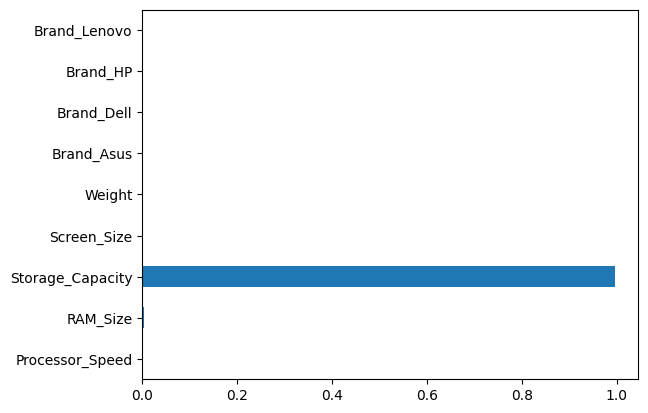

In [ ]:
regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(x, y)
feat_importances = pd.Series(regr.feature_importances_, index=x.columns)
feat_importances.plot(kind='barh')

Random Forest(алгоритм не из задания) тоже говорит что Capacity больше всего влияет на ценообразование - остальное ничтожно мало

In [ ]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Processor_Speed   1000 non-null   float64
 1   RAM_Size          1000 non-null   int64  
 2   Storage_Capacity  1000 non-null   int64  
 3   Screen_Size       1000 non-null   float64
 4   Weight            1000 non-null   float64
 5   Price             1000 non-null   float64
 6   Brand_Asus        1000 non-null   uint8  
 7   Brand_Dell        1000 non-null   uint8  
 8   Brand_HP          1000 non-null   uint8  
 9   Brand_Lenovo      1000 non-null   uint8  
dtypes: float64(4), int64(2), uint8(4)
memory usage: 50.9 KB


(array([355.,   2.,   0., 296.,  11.,   0.,   0.,   0.,   4., 332.]),
 array([ 8570.01295047, 11063.40515915, 13556.79736784, 16050.18957652,
        18543.58178521, 21036.97399389, 23530.36620258, 26023.75841126,
        28517.15061995, 31010.54282863, 33503.93503731]),
 <BarContainer object of 10 artists>)

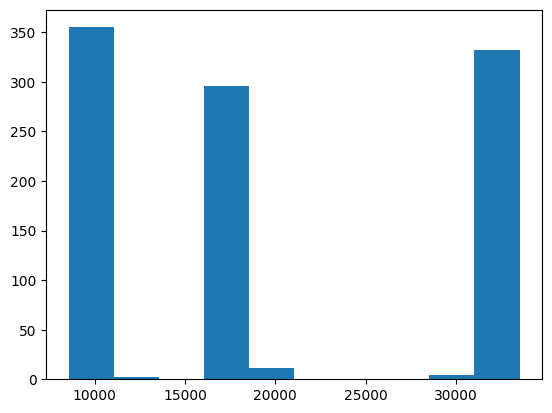

In [ ]:
plt.hist(encoded_data.Price)

Видим что наше ценообразование разбивается по сути на 3 группы, т.е можно представить задачу как задачу классификации по трем этим группам

In [ ]:
def f(x) -> str:
  if x < 16000:
    return '1'
  elif x < 25000:
    return '2'
  else:
    return '3'


In [ ]:
encoded_data["category"] = encoded_data[target].apply(f)

In [ ]:
encoded_data

,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price,Brand_Asus,Brand_Dell,Brand_HP,Brand_Lenovo,category
0,3.830296,16,512,11.185147,2.641094,17395.093065,1,0,0,0,2
1,2.912833,4,1000,11.311372,3.260012,31607.605919,0,0,0,0,3
2,3.241627,4,256,11.853023,2.029061,9291.023542,0,0,0,1,1
3,3.806248,16,512,12.280360,4.573865,17436.728334,0,0,0,0,2
4,3.268097,32,1000,14.990877,4.193472,32917.990718,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
995,3.343584,4,1000,12.587095,3.162399,31593.668017,0,0,1,0,3
996,2.780555,8,256,12.679356,3.750265,9149.521832,0,1,0,0,1
997,3.200569,4,512,12.666315,3.392612,16552.404779,0,1,0,0,2
998,1.604182,8,256,11.215581,3.857613,9407.473459,1,0,0,0,1


In [ ]:
import pandas as pd
import numpy as np
from math import log2
from typing import List, Any, Dict, Tuple

def calculate_category_probabilities(x: pd.Series, category_col: str ="category") -> List[float]:
    categories = x[category_col].unique()
    probabilities = [x[x[category_col] == category].shape[0] / x.shape[0] for category in categories]
    return probabilities

def calc_entropy(p: List[float]) -> float:
    return sum([-p_i * log2(p_i) if p_i != 0 else 0 for p_i in p])

def gain_ratio(dataset: pd.DataFrame, target_col: str = "target", category_col: str = "category") -> Dict[Any, Tuple[float, float]]:
    x = dataset
    p = calculate_category_probabilities(x, category_col)
    h_x = calc_entropy(p)
    print(h_x)
    res = {}
    gain_ratio_value = 0

    for column in dataset.columns:
        max_gain_ratio = float("-inf")
        if column == target_col or column == category_col:
            continue

        best_value = float("-inf")
        for value in dataset[column].unique():
            x_l = dataset.loc[dataset[column] <= value]
            x_r = dataset.loc[dataset[column] > value]

            p_l = calculate_category_probabilities(x_l, category_col)
            p_r = calculate_category_probabilities(x_r, category_col)

            h_x_l = calc_entropy(p_l)
            h_x_r = calc_entropy(p_r)

            gain_ratio_value = h_x - (x_l.shape[0] / x.shape[0]) * h_x_l - (x_r.shape[0] / x.shape[0]) * h_x_r
            if gain_ratio_value > max_gain_ratio:
                max_gain_ratio = gain_ratio_value
                best_value = value
                res[column] = (best_value, gain_ratio_value)

    return res

[0.307, 0.336, 0.357]
1.5822209588213898
[0.307, 0.336, 0.357]


In [ ]:
encoded_data.head()


,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price,Brand_Asus,Brand_Dell,Brand_HP,Brand_Lenovo,category
0,3.830296,16,512,11.185147,2.641094,17395.093065,1,0,0,0,2
1,2.912833,4,1000,11.311372,3.260012,31607.605919,0,0,0,0,3
2,3.241627,4,256,11.853023,2.029061,9291.023542,0,0,0,1,1
3,3.806248,16,512,12.280360,4.573865,17436.728334,0,0,0,0,2
4,3.268097,32,1000,14.990877,4.193472,32917.990718,0,0,0,0,3


In [ ]:
features_with_gains = gain_ratio(encoded_data, target_col=target, category_col="category")
print(features_with_gains)
selected_gain_features = sorted(features_with_gains, key=lambda x: list(x)[1], reverse=True)
selected_gain_features



1.5822209588213898
{'Processor_Speed': (1.756274319976698, 0.006288833260738924), 'RAM_Size': (4, 0.000909335591757543), 'Storage_Capacity': (256, 0.9401647521318282), 'Screen_Size': (16.95017644023471, 0.006316797475793834), 'Weight': (2.004931271337349, 0.005964909828616305), 'Brand_Asus': (0, 0.0018516384746549153), 'Brand_Dell': (0, 0.0014558439647832655), 'Brand_HP': (0, 0.002017598825981737), 'Brand_Lenovo': (0, 0.0020357351369605925)}


['Storage_Capacity',
 'Processor_Speed',
 'Brand_Asus',
 'Brand_Dell',
 'Brand_HP',
 'Brand_Lenovo',
 'Weight',
 'Screen_Size',
 'RAM_Size']

Вывод о Storage capacity, подверждается
он оказывает самое большее влияние на ценообразование.
Даже нет смысла брать proc speed, потому что он много меньше чем Capacity

In [ ]:
import unittest

from scipy.stats import entropy




class TestDecisionTreeMethods(unittest.TestCase):

    def setUp(self)-> None:
        self.dataset = pd.DataFrame({'age': [50, 55, 52, 48, 48],
        'api_hi': [110, 140, 130, 150, 100],
        'cardio': [0, 1, 1, 1, 0]}
        )

    def compare_results(self, result1, result2, places=2) -> None:
      for (key1, value1), (key2, value2) in zip(result1, result2):
          if isinstance(value1, (int, float)) and isinstance(value2, (int, float)):
              self.assertAlmostEqual(key1, key2, places=places)
              self.assertAlmostEqual(float(value1), float(value2), places=places)
          elif isinstance(value1, str) and isinstance(value2, str):
              self.assertEqual(value1, value2)
          else:
              self.fail("Incompatible types for comparison: {} and {}".format(type(value1), type(value2)))


    def test_calc_entropy_with_two_probabilities(self) -> None:
        probabilities = [0.4, 0.6]
        calculated_entropy = calc_entropy(probabilities)
        expected_entropy = entropy(probabilities, base=2)
        self.assertAlmostEqual(calculated_entropy, expected_entropy, places=5)

    def test_calc_entropy_with_equal_probabilities(self) -> None:
        probabilities = [0.2, 0.2, 0.2, 0.2, 0.2]
        calculated_entropy = calc_entropy(probabilities)
        expected_entropy = entropy(probabilities, base=2)
        self.assertAlmostEqual(calculated_entropy, expected_entropy, places=5)

    def test_calc_entropy_with_single_probability(self) -> None:
        probabilities = [1.0]
        calculated_entropy = calc_entropy(probabilities)
        expected_entropy = entropy(probabilities, base=2)
        self.assertAlmostEqual(calculated_entropy, expected_entropy, places=5)

    def test_category_probabilities(self) -> None:
        category_col = 'cardio'
        probabilities = calculate_category_probabilities(self.dataset, category_col)
        expected_probabilities = [0.4, 0.6]
        self.assertEqual(probabilities, expected_probabilities)

    def test_calc_entropy_with_empty_probabilities(self) -> None:
        probabilities = []
        calculated_entropy = calc_entropy(probabilities)
        expected_entropy = 0.0
        self.assertEqual(calculated_entropy, expected_entropy)

    def assertAlmostEqualArray(self, array1, array2, places=1) -> None:
        for item1, item2 in zip(array1, array2):
            self.assertEqual(item1[0], item2[0])
            self.assertEqual(item1[1], item2[1])
            self.assertAlmostEqual(item1[2], item2[2], places=places)

    def test_category_probabilities_with_all_same_values(self) -> None:
        dataset = pd.DataFrame({'age': [40, 40, 40, 40, 40],
                                'api_hi': [120, 130, 110, 140, 100],
                                'cardio': [1, 1, 1, 1, 1]})
        category_col = 'cardio'
        probabilities = calculate_category_probabilities(dataset, category_col)
        expected_probabilities = [1.0]
        self.assertEqual(probabilities, expected_probabilities)


    def test_gain_ratio(self) -> None:
        target_col = 'cardio'
        category_col = 'cardio'
        best_splits = gain_ratio(self.dataset, target_col, category_col)
        expected_result = [('age', 0.42), ('api_hi', 0.97)]
        actual_result = [(key, value[1]) for key, value in best_splits.items()]
        self.compare_results(expected_result, actual_result, places=2)

    def test_gain_ratio_with_empty_dataset(self) -> None:
        # Test when the dataset is empty
        empty_dataset = pd.DataFrame(columns=['age', 'api_hi', 'cardio'])
        target_col = 'cardio'
        category_col = 'age'
        best_splits = gain_ratio(empty_dataset, target_col, category_col)
        self.assertEqual(best_splits, {})


unittest.main(argv=['first-arg-is-ignored'], exit=False)

........
----------------------------------------------------------------------
Ran 8 tests in 0.059s

OK


0.9709505944546686
0
